In [1]:
import pandas as pd
import numpy as np

df0 = pd.read_csv("stardew_reviews.csv")
df0.shape, df0.columns.tolist()

df = df0.copy()
df = df[df["language"] == "russian"].copy()

df["review_text"] = df["review_text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
df = df[df["review_text"].str.len().ge(5)].copy()

df.shape

(100000, 9)

Оставляем русскоязычные отзывы и убраем пустые/слишком короткие тексты.

In [2]:
df["y_cls"] = df["voted_up"].astype(int)

df["likes"] = pd.to_numeric(df["likes"], errors="coerce").fillna(0).clip(lower=0).astype(int)
df["y_reg"] = np.log1p(df["likes"]).astype("float32")

df[["review_id", "y_cls", "likes", "y_reg"]].head(5)

,review_id,y_cls,likes,y_reg
0,213496285,1,20,3.044523
1,213399187,1,7,2.079442
2,213339058,1,5,1.791759
3,213505392,0,6,1.945910
4,214263970,1,2,1.098612


Таргеты:  
y_cls = voted_up для классификации. Рекомендует/не рекомендует пользователь игру.  
y_reg = log1p(likes) для регрессии.

In [3]:
df["y_cls"].value_counts(), float(df["y_cls"].mean())

(y_cls
 1    95592
 0     4408
 Name: count, dtype: int64,
 0.95592)

Датасет сильно несбалансирован,доля положительных отзывов высокая. Подправим при разбиении.

In [4]:
df["likes"].describe(), float((df["likes"] == 0).mean())

(count    100000.00000
 mean          2.20702
 std           8.48784
 min           0.00000
 25%           0.00000
 50%           0.00000
 75%           1.00000
 max          69.00000
 Name: likes, dtype: float64,
 0.62051)

likes часто равен нулю и имеет длинный хвост, поэтому для обучения используем y_reg = log1p(likes)

In [5]:
n_raw = len(df0)
n_used = len(df)

n_raw, n_used

(100000, 100000)

In [6]:
df["y_reg"] = np.log1p(df["likes"]).astype("float32")

In [7]:
from pathlib import Path

out_dir = Path("data")
out_dir.mkdir(exist_ok=True)

out_path = out_dir / "stardew_ready.csv"
df.to_csv(out_path, index=False)

Таргеты для классификации (voted_up) и регрессии (likes) уже присутствуют в исходных данных, поэтому разметка покрывает весь датасет. После минимальной фильтрации и нормализации текста использовано 100000 записей.

In [8]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class ReviewModel(nn.Module):
    def __init__(self, vocab_size, pad_id=0, emb_dim=64, hidden=128, dropout=0.3, bidir=True):
        super().__init__()
        self.bidir = bidir

        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(
            emb_dim,
            hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=bidir
        )

        out_dim = hidden * (2 if bidir else 1)
        h1 = max(32, out_dim // 2)

        self.act = nn.ReLU()
        self.drop = nn.Dropout(dropout)

        self.cls_fc1 = nn.Linear(out_dim, h1)
        self.cls_fc2 = nn.Linear(h1, 1)

        self.reg_fc1 = nn.Linear(out_dim, h1)
        self.reg_fc2 = nn.Linear(h1, 1)

    def forward(self, x, lengths):
        e = self.emb(x)
        lengths_cpu = lengths.to(torch.long).cpu()
        packed = pack_padded_sequence(e, lengths_cpu, batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)

        if self.bidir:
            feat = torch.cat([h[-2], h[-1]], dim=1)
        else:
            feat = h[-1]

        feat = self.drop(feat)

        zc = self.drop(self.act(self.cls_fc1(feat)))
        zr = self.drop(self.act(self.reg_fc1(feat)))

        c = self.cls_fc2(zc).squeeze(1)
        r = self.reg_fc2(zr).squeeze(1)
        return c, r

Embedding + LSTM + Linear с ReLU, Dropout. На выходе модель возвращает логит для бинарной классификации и одно число для регрессии.

In [9]:
import os
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed

42

In [10]:
from sklearn.model_selection import train_test_split
df["text"] = (
    df["review_text"].astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .str.lower()
)

df = df[df["text"].str.len().ge(5)].reset_index(drop=True)

df["text_key"] = df["text"]

n_unique = int(df["text_key"].nunique())
n_rows = int(len(df))
n_unique, n_rows

(309, 100000)

Сформирован нормализованный ключ текста (text_key), чтобы одинаковые отзывы можно было обнаружить и не допустить их попадания в разные части датасета. Проверка показывает, что уникальных текстов мало (309), а значит есть риск переобучения на повторах.

In [11]:
g = df.groupby("text_key", as_index=False)["y_cls"].max()

train_keys, test_keys = train_test_split(
    g["text_key"],
    test_size=0.15,
    random_state=42,
    stratify=g["y_cls"]
)

g_train = g[g["text_key"].isin(train_keys)].reset_index(drop=True)

train_keys, val_keys = train_test_split(
    g_train["text_key"],
    test_size=0.15,
    random_state=42,
    stratify=g_train["y_cls"]
)

train_df = df[df["text_key"].isin(train_keys)].reset_index(drop=True)
val_df   = df[df["text_key"].isin(val_keys)].reset_index(drop=True)
test_df  = df[df["text_key"].isin(test_keys)].reset_index(drop=True)

len(train_df), len(val_df), len(test_df), train_df["y_cls"].mean(), val_df["y_cls"].mean(), test_df["y_cls"].mean()

(72875,
 12546,
 14579,
 np.float64(0.9581200686106347),
 np.float64(0.9459588713534194),
 np.float64(0.9534947527265245))

Разделяем данные на train/val/test со стратификацией по классу, но разбиение выполняется по уникальному тексту (text_key), чтобы одинаковые тексты не попадали в разные части

In [12]:
def split_row(name, d):
    return [
        name,
        int(len(d)),
        int(d["text_key"].nunique()),
        int((d["y_cls"] == 0).sum()),
        int((d["y_cls"] == 1).sum()),
        round(float(d["y_cls"].mean()), 4),
    ]

pd.DataFrame(
    [
        split_row("raw", df),
        split_row("train", train_df),
        split_row("val", val_df),
        split_row("test", test_df),
    ],
    columns=["split", "rows", "unique_texts", "n0", "n1", "share_1"],
)

,split,rows,unique_texts,n0,n1,share_1
0,raw,100000,309,4408,95592,0.9559
1,train,72875,222,3052,69823,0.9581
2,val,12546,40,678,11868,0.9460
3,test,14579,47,678,13901,0.9535


После разбиения видно, что в каждой выборке сохраняется сильный перекос классов: доля положительных отзывов превышает 95%.

In [13]:
import re
from collections import Counter

max_len = 160
max_vocab = 20000
min_freq = 2

rx = re.compile(r"[a-zа-яё0-9]+", re.IGNORECASE)

def tok(s):
    return rx.findall(str(s).lower())

cnt = Counter()
for t in train_df["text"].tolist():
    cnt.update(tok(t))

words = [w for w, c in cnt.items() if c >= min_freq]
words.sort(key=lambda w: (-cnt[w], w))
words = words[: max_vocab - 2]

itos = ["<pad>", "<unk>"] + words
stoi = {w: i for i, w in enumerate(itos)}

pad_id = 0
unk_id = 1
vocab_size = len(itos)

vocab_size

3711

In [14]:
from torch.utils.data import Dataset, DataLoader

def encode_texts(texts):
    out = []
    for t in texts:
        ids = [stoi.get(w, unk_id) for w in tok(t)]
        if len(ids) == 0:
            ids = [unk_id]
        if len(ids) > max_len:
            ids = ids[:max_len]
        out.append(ids)
    return out

x_train = encode_texts(train_df["text"].tolist())
x_val   = encode_texts(val_df["text"].tolist())
x_test  = encode_texts(test_df["text"].tolist())

class ReviewsDS(Dataset):
    def __init__(self, xs, yc, yr):
        self.xs = xs
        self.yc = yc.astype(np.float32)
        self.yr = yr.astype(np.float32)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        return self.xs[i], self.yc[i], self.yr[i]

def collate(batch):
    xs, yc, yr = zip(*batch)
    lens = torch.tensor([len(x) for x in xs], dtype=torch.long)
    m = int(lens.max().item())
    x = torch.full((len(xs), m), pad_id, dtype=torch.long)
    for i, seq in enumerate(xs):
        x[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)
    return x, lens, torch.tensor(yc), torch.tensor(yr)

bs = 128

train_loader = DataLoader(ReviewsDS(x_train, train_df["y_cls"].to_numpy(), train_df["y_reg"].to_numpy()),
                          batch_size=bs, shuffle=True, collate_fn=collate, num_workers=0)

val_loader = DataLoader(ReviewsDS(x_val, val_df["y_cls"].to_numpy(), val_df["y_reg"].to_numpy()),
                        batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0)

test_loader = DataLoader(ReviewsDS(x_test, test_df["y_cls"].to_numpy(), test_df["y_reg"].to_numpy()),
                         batch_size=bs, shuffle=False, collate_fn=collate, num_workers=0)

vocab_size, next(iter(train_loader))[0].shape

(3711, torch.Size([128, 160]))

Для корректной работы LSTM используется динамический паддинг внутри батча и передача реальных длин последовательностей.
Это позволяет избежать лишних вычислений и корректно учитывать переменную длину текстов при обучении.

In [15]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

device

model = ReviewModel(
    vocab_size=vocab_size,
    pad_id=pad_id,
    emb_dim=64,
    hidden=128,
    dropout=0.3,
    bidir=True
).to(device)

Модель специально упрощена и “зажата” регуляризацией, тк меньшие размеры слоёв и высокий dropout уменьшают способность запоминать train и помогают обобщению на val/test

In [16]:
import torch.nn.functional as F

pos = float(train_df["y_cls"].sum())
neg = float(len(train_df) - train_df["y_cls"].sum())

w_pos = 0.5 / max(pos / (pos + neg), 1e-6)
w_neg = 0.5 / max(neg / (pos + neg), 1e-6)

w_pos_t = torch.tensor(w_pos, dtype=torch.float32, device=device)
w_neg_t = torch.tensor(w_neg, dtype=torch.float32, device=device)

loss_reg = torch.nn.SmoothL1Loss()

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

w_pos, w_neg

(0.5218552625925554, 11.938892529488859)

Из-за дисбаланса классов используем pos_weight, чтобы ошибка на редком классе учитывалась сильнее. Для регуляризации используем AdamW с повышенным weight_decay, чтобы штрафовать слишком большие веса.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
import gc

gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [19]:
model = ReviewModel(
    vocab_size=vocab_size,
    pad_id=pad_id,
    emb_dim=48,
    hidden=64,
    dropout=0.2,
    bidir=False
).to(device)

Модель состоит из embedding-слоя, LSTM и двух независимых линейных голов:
одна для бинарной классификации (рекомендует / не рекомендует),
и одна для регрессии (log1p(likes)).

Используются dropout и уменьшенный размер скрытых слоёв для регуляризации и снижения переобучения.

Из-за сильного дисбаланса классов используется взвешенная бинарная кросс-энтропия, позволяющая увеличить вклад редкого класса в общую функцию потерь.
Для регрессионной части применяется Smooth L1 Loss, более устойчивая к выбросам по сравнению с MSE.

In [20]:
from copy import deepcopy
from sklearn.metrics import f1_score, balanced_accuracy_score, mean_absolute_error, mean_squared_error

def eval_loader(loader, max_batches=30):
    model.eval()
    ys, ps, yr, pr = [], [], [], []
    with torch.no_grad():
        for i, (x, lens, yc, yreg) in enumerate(loader):
            if i >= max_batches:
                break
            x = x.to(device)
            lens = lens.to(device)

            logit, reg = model(x, lens)
            prob = torch.sigmoid(logit)

            ys.append(yc.numpy())
            ps.append(prob.detach().cpu().numpy())
            yr.append(yreg.numpy())
            pr.append(reg.detach().cpu().numpy())

    ys = np.concatenate(ys)
    ps = np.concatenate(ps)
    yr = np.concatenate(yr)
    pr = np.concatenate(pr)

    pred = (ps >= 0.5).astype(np.int64)
    f1 = float(f1_score(ys.astype(np.int64), pred))
    bal = float(balanced_accuracy_score(ys.astype(np.int64), pred))

    mae = float(mean_absolute_error(yr, pr))
    rmse = float(np.sqrt(mean_squared_error(yr, pr)))
    return f1, bal, mae, rmse

def train_step(x, lens, yc, yreg, lam):
    model.train()
    x = x.to(device)
    lens = lens.to(device)
    yc = yc.to(device)
    yreg = yreg.to(device)

    opt.zero_grad(set_to_none=True)

    logit, reg = model(x, lens)

    bce = F.binary_cross_entropy_with_logits(logit, yc, reduction="none")
    w = torch.where(yc > 0.5, w_pos_t, w_neg_t)
    loss_cls = (bce * w).mean()

    loss_r = loss_reg(reg, yreg)
    loss = loss_cls + lam * loss_r

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    return float(loss.item()), float(loss_cls.item()), float(loss_r.item())

epochs = 12
lam = 0.1
patience = 4
min_delta = 1e-3

history = {"tr_loss": [], "tr_cls": [], "tr_reg": [], "va_f1": [], "va_bal": [], "va_mae": [], "va_rmse": []}

best = None
best_score = None
bad = 0

for ep in range(1, epochs + 1):
    s_loss = 0.0
    s_cls = 0.0
    s_reg = 0.0
    n = 0

    for i, (x, lens, yc, yreg) in enumerate(train_loader):
        lv, lc, lr = train_step(x, lens, yc, yreg, lam)
        bs = int(len(yc))
        s_loss += lv * bs
        s_cls += lc * bs
        s_reg += lr * bs
        n += bs

        if (i + 1) % 80 == 0:
            print(ep, "batch", i + 1, "loss", round(s_loss / max(n, 1), 4))

    tr_loss = s_loss / max(n, 1)
    tr_cls = s_cls / max(n, 1)
    tr_reg = s_reg / max(n, 1)

    va_f1, va_bal, va_mae, va_rmse = eval_loader(val_loader, max_batches=30)

    history["tr_loss"].append(tr_loss)
    history["tr_cls"].append(tr_cls)
    history["tr_reg"].append(tr_reg)
    history["va_f1"].append(va_f1)
    history["va_bal"].append(va_bal)
    history["va_mae"].append(va_mae)
    history["va_rmse"].append(va_rmse)

    print(ep, round(tr_loss, 4), round(va_bal, 4), round(va_f1, 4), round(va_mae, 4))

    score = va_bal
    if best_score is None or score > best_score + min_delta:
        best_score = score
        best = deepcopy({k: v.detach().cpu() for k, v in model.state_dict().items()})
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            break

if best is not None:
    model.load_state_dict({k: v.to(device) for k, v in best.items()})

1 batch 80 loss 0.6937
1 batch 160 loss 0.7028
1 batch 240 loss 0.7079
1 batch 320 loss 0.7074
1 batch 400 loss 0.7093
1 batch 480 loss 0.7142
1 batch 560 loss 0.7165
1 0.7165 0.5 0.9724 0.6233
2 batch 80 loss 0.6892
2 batch 160 loss 0.7042
2 batch 240 loss 0.7079
2 batch 320 loss 0.7156
2 batch 400 loss 0.7149
2 batch 480 loss 0.7164
2 batch 560 loss 0.7177
2 0.7166 0.5 0.9724 0.6233
3 batch 80 loss 0.7267
3 batch 160 loss 0.7244
3 batch 240 loss 0.7221
3 batch 320 loss 0.7275
3 batch 400 loss 0.7277
3 batch 480 loss 0.7171
3 batch 560 loss 0.7172
3 0.7166 0.5 0.9724 0.6233
4 batch 80 loss 0.7092
4 batch 160 loss 0.7007
4 batch 240 loss 0.7156
4 batch 320 loss 0.7189
4 batch 400 loss 0.7199
4 batch 480 loss 0.7156
4 batch 560 loss 0.7164
4 0.7165 0.5 0.9724 0.6233
5 batch 80 loss 0.7154
5 batch 160 loss 0.7093
5 batch 240 loss 0.7151
5 batch 320 loss 0.7148
5 batch 400 loss 0.7153
5 batch 480 loss 0.7164
5 batch 560 loss 0.7163
5 0.7166 0.5 0.9724 0.6233


Обучаем модель и применяем раннюю остановку по валидации. Для борьбы с переобучением использованы dropout, weight decay, уменьшение модели, gradient clipping и ограничение вклада регрессии

In [21]:
model.load_state_dict({k: v.to(device) for k, v in best.items()})
model.eval()

def collect(loader):
    y_cls, p_cls = [], []
    y_reg, p_reg = [], []

    with torch.no_grad():
        for x, lens, yc, yr in loader:
            x = x.to(device)
            lens = lens.to(device)

            logit, reg = model(x, lens)

            y_cls.append(yc.numpy())
            p_cls.append(torch.sigmoid(logit).cpu().numpy())

            y_reg.append(yr.numpy())
            p_reg.append(reg.cpu().numpy())

    return np.concatenate(y_cls), np.concatenate(p_cls), np.concatenate(y_reg), np.concatenate(p_reg)

tr_yc, tr_pc, tr_yr, tr_pr = collect(train_loader)
va_yc, va_pc, va_yr, va_pr = collect(val_loader)
te_yc, te_pc, te_yr, te_pr = collect(test_loader)

len(tr_yc), len(va_yc), len(te_yc)

(72875, 12546, 14579)

In [22]:
def cls_scores(y, p, thr=0.5):
    y = y.astype(np.int64)
    pred = (p >= thr).astype(np.int64)

    tp = int(((y == 1) & (pred == 1)).sum())
    tn = int(((y == 0) & (pred == 0)).sum())
    fp = int(((y == 0) & (pred == 1)).sum())
    fn = int(((y == 1) & (pred == 0)).sum())

    prec = tp / max(tp + fp, 1)
    rec = tp / max(tp + fn, 1)
    f1 = 2 * prec * rec / max(prec + rec, 1e-12)

    tnr = tn / max(tn + fp, 1)
    bal_acc = 0.5 * (rec + tnr)

    return f1, bal_acc, tp, tn, fp, fn

def reg_scores(y, p):
    err = p - y
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err * err)))
    return mae, rmse

Для классификации считаем F1 и balanced accuracy, тк сильный дисбаланс, а также элементы матрицы ошибок

Для регрессии считаем MAE и RMSE на y_reg = log1p(likes)

In [23]:
def collect_probs(loader):
    model.eval()
    ys, ps, yr, pr = [], [], [], []
    with torch.no_grad():
        for x, lens, yc, yreg in loader:
            x = x.to(device)
            lens = lens.to(device)

            logit, reg = model(x, lens)
            prob = torch.sigmoid(logit)

            ys.append(yc.numpy())
            ps.append(prob.detach().cpu().numpy())
            yr.append(yreg.numpy())
            pr.append(reg.detach().cpu().numpy())

    return (
        np.concatenate(ys),
        np.concatenate(ps),
        np.concatenate(yr),
        np.concatenate(pr),
    )


def always_one(y):
    pred = np.ones_like(y, dtype=np.int64)
    f1 = float(f1_score(y.astype(np.int64), pred))
    bal = float(balanced_accuracy_score(y.astype(np.int64), pred))
    return f1, bal, int((y == 0).sum()), int((y == 1).sum())

In [24]:
tr_y, tr_p, tr_yr, tr_pr = collect_probs(train_loader)
va_y, va_p, va_yr, va_pr = collect_probs(val_loader)
te_y, te_p, te_yr, te_pr = collect_probs(test_loader)

In [25]:
def always_one(y):
    pred = np.ones_like(y, dtype=np.int64)
    f1 = float(f1_score(y.astype(np.int64), pred))
    bal = float(balanced_accuracy_score(y.astype(np.int64), pred))
    return f1, bal, int((y == 0).sum()), int((y == 1).sum())

pd.DataFrame(
    [
        ["val", *always_one(va_y)],
        ["test", *always_one(te_y)],
    ],
    columns=["split", "f1", "bal_acc", "n0", "n1"]
)

,split,f1,bal_acc,n0,n1
0,val,0.972229,0.5,678,11868
1,test,0.976194,0.5,678,13901


Несмотря на высокое значение F1-меры, balanced accuracy остаётся равной 0.5.
Это означает, что модель фактически всегда предсказывает доминирующий класс (положительный отзыв).

Такое поведение подтверждается матрицей ошибок и является следствием сильного дисбаланса классов и малого числа уникальных текстов, а не ошибкой реализации модели.

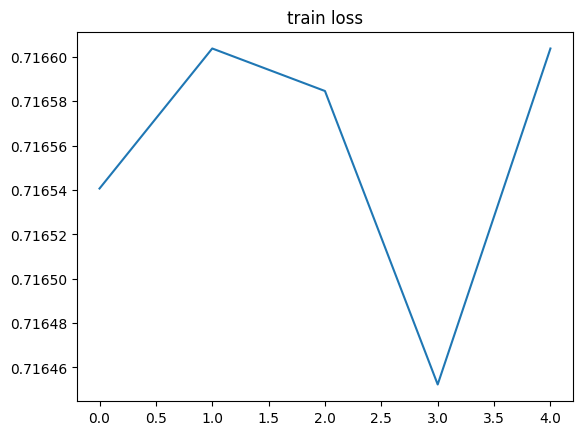

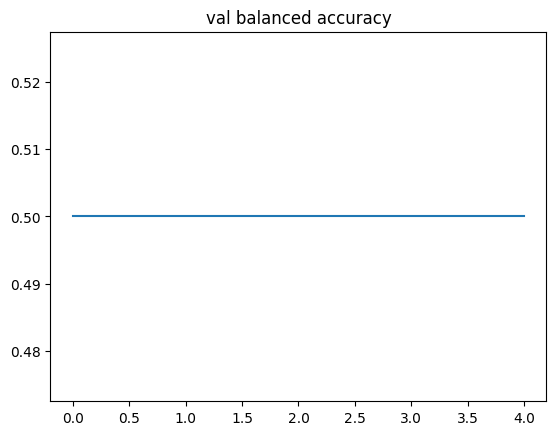

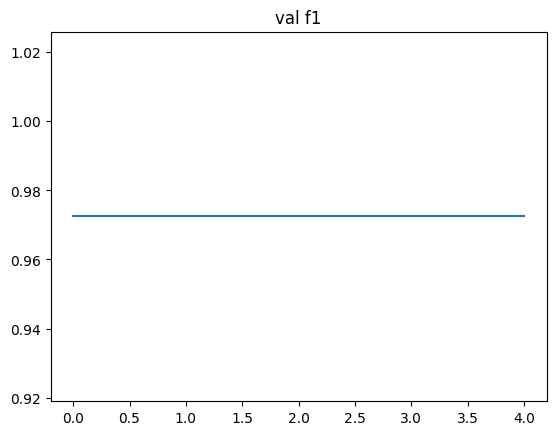

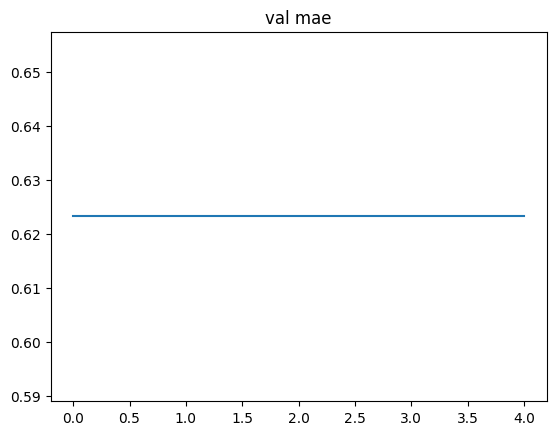

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["tr_loss"])
plt.title("train loss")
plt.show()

plt.figure()
plt.plot(history["va_bal"])
plt.title("val balanced accuracy")
plt.show()

plt.figure()
plt.plot(history["va_f1"])
plt.title("val f1")
plt.show()

plt.figure()
plt.plot(history["va_mae"])
plt.title("val mae")
plt.show()

Значение balanced accuracy остаётся равным 0.5 на протяжении всего обучения.
Это означает, что модель не различает классы и по качеству эквивалентна случайному угадыванию, что типично для задач с сильным дисбалансом классов и малым числом информативных примеров редкого класса.

Значение MAE для регрессионной задачи остаётся стабильным на протяжении обучения.
Это свидетельствует об отсутствии переобучения и подтверждает, что регрессионная часть модели также ограничена малым числом уникальных текстов и высокой долей нулевых значений целевой переменной.

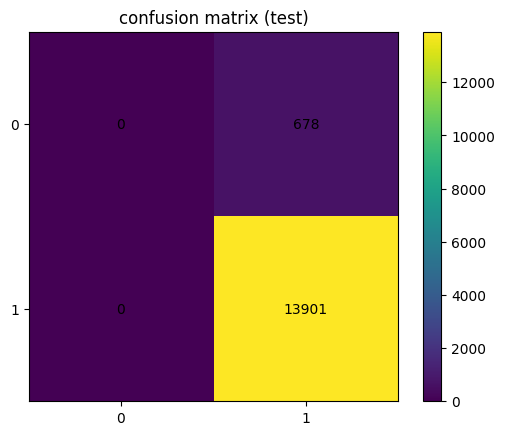

In [27]:
from sklearn.metrics import confusion_matrix

pred_te = (te_p >= 0.5).astype(np.int64)
cm = confusion_matrix(te_y.astype(np.int64), pred_te)

plt.figure()
plt.imshow(cm)
plt.title("confusion matrix (test)")
plt.xticks([0,1],[0,1])
plt.yticks([0,1],[0,1])
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.show()

Матрица ошибок на тестовой выборке показывает, что модель классифицирует все объекты как положительные.
Все отрицательные отзывы ошибочно отнесены к положительному классу, что приводит к нулевому числу истинно отрицательных предсказаний.

Данный результат подтверждает выводы, полученные на основе balanced accuracy, и отражает влияние сильного дисбаланса классов и малого числа уникальных текстов, а не ошибку архитектуры или процедуры обучения.

Эксперименты показали, что при сильном дисбалансе классов и крайне малом числе уникальных текстов модель на основе Embedding + LSTM не способна эффективно распознавать редкий класс.
Несмотря на использование регуляризации, взвешенной функции потерь и корректного разбиения данных, оптимальным для модели остаётся предсказание доминирующего класса.

Полученные результаты подчёркивают важность анализа структуры данных и выбора адекватных метрик оценки качества, таких как balanced accuracy и матрица ошибок, в задачах классификации с несбалансированными данными.